In [418]:
import pandas as pd
import seaborn as sns
import json 
import numpy as np
from collections import OrderedDict
from scipy import interpolate


# Get Market depth and slippage model

In [541]:
df = pd.read_csv("additional_data/Total market.csv")
df["2% Depth"] = pd.to_numeric(df["2% Depth"].str.replace(",","").str.replace("$",""))
df["-2% Depth"] = pd.to_numeric(df["-2% Depth"].str.replace(",","").str.replace("$",""))
df.head(2)

def get_total_market_1(x):
    return x*1.02*100

def get_total_market_2(x):
    return x*0.98*100

df["Total market 1"] = df["2% Depth"].apply(get_total_market_2)
df["Total market 2"] = df["-2% Depth"].apply(get_total_market_1)
df["Total market"] = (df["Total market 1"] + df["Total market 2"])/2

total_market = df[df.Pair.str.contains("/US")]["Total market"].sum()
print("Total Market depth", total_market)

Total Market depth 34420437392.0


/tmp/ipykernel_5680/2941934132.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["2% Depth"] = pd.to_numeric(df["2% Depth"].str.replace(",","").str.replace("$",""))
/tmp/ipykernel_5680/2941934132.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df["-2% Depth"] = pd.to_numeric(df["-2% Depth"].str.replace(",","").str.replace("$",""))


/home/alejandro/.local/share/virtualenvs/investigations-l37Vbzt9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

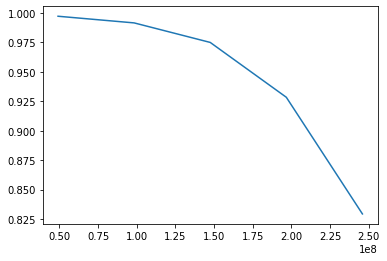

In [543]:
def get_slippage_dollars(x,market):
    return 1/(1+2*x/market)
k = 49165592
sns.lineplot([k, k*2, k*3, k*4, k*5, ],[get_slippage_dollars(x,total_market) for x in [k, k*3, k*9, k*27, k*72, ]])

# Transform compound data to debt curve and  slippage

In [449]:
eth_compound = json.load(open("additional_data/ethereum_compound.json"))
m_status = json.load(open("additional_data/compmound_markets_status.json"))
m_dict = dict(zip([i  for i in m_status], [m_status[i]["symbol"] for i in m_status]))
m_dict

{'0x6C8c6b02E7b2BE14d4fA6022Dfd6d75921D90E4E': 'BAT',
 '0x5d3a536E4D6DbD6114cc1Ead35777bAB948E3643': 'DAI',
 '0x4Ddc2D193948926D02f9B1fE9e1daa0718270ED5': 'ETH',
 '0x158079Ee67Fce2f58472A96584A73C7Ab9AC95c1': 'REP',
 '0x39AA39c021dfbaE8faC545936693aC917d5E7563': 'USDC',
 '0xf650C3d88D12dB855b8bf7D11Be6C55A4e07dCC9': 'USDT',
 '0xC11b1268C1A384e55C48c2391d8d480264A3A7F4': 'WBTC',
 '0xB3319f5D18Bc0D84dD1b4825Dcde5d5f7266d407': 'ZRX',
 '0xF5DCe57282A584D2746FaF1593d3121Fcac444dC': 'unknown',
 '0x35A18000230DA775CAc24873d00Ff85BccdeD550': 'UNI',
 '0x70e36f6BF80a52b3B46b3aF8e106CC0ed743E8e4': 'COMP',
 '0xccF4429DB6322D5C611ee964527D42E5d685DD6a': 'WBTC',
 '0x12392F67bdf24faE0AF363c24aC620a2f67DAd86': 'TUSD',
 '0xFAce851a4921ce59e912d19329929CE6da6EB0c7': 'LINK',
 '0x95b4eF2869eBD94BEb4eEE400a99824BF5DC325b': 'unknown',
 '0x4B0181102A0112A2ef11AbEE5563bb4a3176c9d7': 'SUSHI',
 '0xe65cdB6479BaC1e22340E4E755fAE7E509EcD06c': 'AAVE',
 '0x80a2AE356fc9ef4305676f7a3E2Ed04e12C33946': 'YFI',
 '0x041171

In [461]:
# get the amount of collateral
collaterals = []
values = []
for k in m_dict.keys(): 
    users_with_markets = [i for i in eth_compound["users"] if len(i["markets"])>0]
    collaterals.append(m_dict[k])
    values.append(np.sum([i["markets"][0]["collateral"] for i in users_with_markets if i["markets"][0]["market"]==k ]))
df_collaterals = pd.DataFrame({"collateral": collaterals, "value": values})
df_collaterals_ns = df_collaterals[~df_collaterals.collateral.isin(["DAI","USDC","USDT","TUSD"])]
df_collaterals_ns.value = df_collaterals_ns.value/df_collaterals_ns.value.sum()

/tmp/ipykernel_5680/1802477844.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_collaterals_ns.value = df_collaterals_ns.value/df_collaterals_ns.value.sum()


In [451]:
df_collaterals_ns #everything not stable coin will be first modelled as 80%ETH and 20% BTC, and we will assume that the price of ETH and BTC is fully correlated

,collateral,value
0,BAT,0.028310
2,ETH,0.766361
3,REP,0.000001
6,WBTC,0.009426
7,ZRX,0.002876
8,unknown,0.000551
9,UNI,0.001242
10,COMP,0.052735
11,WBTC,0.135325
13,LINK,0.001719


## Get debt curve and slippage

In [452]:
users_with_markets = [i for i in eth_compound["users"] if len(i["markets"])>0]

/tmp/ipykernel_5680/1490585635.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  return y/x
/home/alejandro/.local/share/virtualenvs/investigations-l37Vbzt9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alejandro/.local/share/virtualenvs/investigations-l37Vbzt9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Cum sum liquidate', ylabel='Value_Perc'>

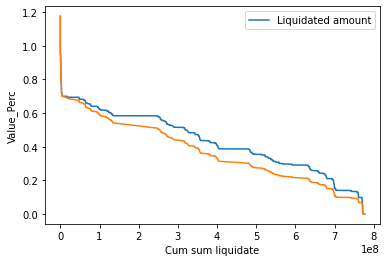

In [544]:
# We need to discount stablecoins
stable_coins_markets = ["0x5d3a536E4D6DbD6114cc1Ead35777bAB948E3643","0x39AA39c021dfbaE8faC545936693aC917d5E7563",
                        "0xf650C3d88D12dB855b8bf7D11Be6C55A4e07dCC9","0x12392F67bdf24faE0AF363c24aC620a2f67DAd86"]

def get_stable_coins (x):
    return np.sum([i["collateral"] for i in x["markets"] if i["market"] in stable_coins_markets])


users_with_markets_and_stable_collat = [
    {**user_data, **{"stable_collateral": get_stable_coins(user_data)}} 
    for user_data in users_with_markets
]


#empezamos con el hipotetico caso de que se liquida cuando hay un 100% del colateral  como deuda
def get_liquidation_value(x, LTV = 0.85):
    return x/LTV

users_with_markets_and_stable_collat_with_liquidation = [
    {**user_data, **{"liquidation_value": get_liquidation_value(user_data["debt"]-(user_data["stable_collateral"]))}} 
    for user_data in users_with_markets_and_stable_collat
]

users_with_markets_and_stable_collat_with_liquidation = [u for u in users_with_markets_and_stable_collat_with_liquidation if u["liquidation_value"]>0]

# lets get the perc of the asset current price needed to trigger liquidation and the volume of that liquidation
def get_liquidation_percentage(x, y):
    return y/x

users_with_markets_and_stable_collat_with_liquidation = [
    {**user_data, **{"liquidation_perc": get_liquidation_percentage(user_data["collateral"]-user_data["stable_collateral"],user_data["liquidation_value"])}} 
    for user_data in users_with_markets_and_stable_collat_with_liquidation
]

df_users = pd.DataFrame(users_with_markets_and_stable_collat_with_liquidation)
df_users['eth_collateral'] = df_users['collateral'] - df_users["stable_collateral"]
df_users = df_users[(df_users.eth_collateral>0)&(df_users.netValue>0)].sort_values("liquidation_perc",ascending=False)
RATIO_ETH_COLLATERAL = 0.8
#df_users = df_users[df_users["liquidation_perc"]<1].sort_values("liquidation_perc",ascending=False)
df_users['Cum sum liquidate'] = df_users['eth_collateral'].cumsum()*RATIO_ETH_COLLATERAL # the amount of ETH that will be liquidated and sold is 80% of the collateral
df_users["Value_Perc"] = df_users["liquidation_perc"]
RATIO_COMPOUND_INDSUTRY = 0.1
df_users['Slippage liquidate'] = get_slippage_dollars(df_users['Cum sum liquidate']/RATIO_COMPOUND_INDSUTRY,total_market) # tenemos que añadir la proporcion de esto del mercado 
df_users['After Slippage effect'] = df_users['Value_Perc']*df_users['Slippage liquidate']
df_users["non_stable_coll"] = df_users["collateral"] - df_users["stable_collateral"]


sns.lineplot(df_users["Cum sum liquidate"],df_users["Value_Perc"], label="Liquidated amount")
sns.lineplot(df_users["Cum sum liquidate"],df_users["After Slippage effect"])

/home/alejandro/.local/share/virtualenvs/investigations-l37Vbzt9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alejandro/.local/share/virtualenvs/investigations-l37Vbzt9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Value_Perc', ylabel='Cum sum liquidate'>

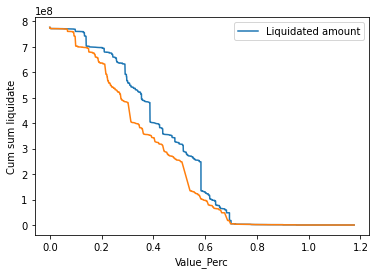

In [540]:
sns.lineplot(df_users["Value_Perc"],df_users["Cum sum liquidate"], label="Liquidated amount")
sns.lineplot(df_users["After Slippage effect"],df_users["Cum sum liquidate"])

/home/alejandro/.local/share/virtualenvs/investigations-l37Vbzt9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alejandro/.local/share/virtualenvs/investigations-l37Vbzt9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Value_Perc', ylabel='Cum sum liquidate'>

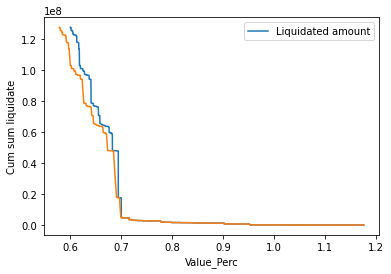

In [537]:
sns.lineplot(df_users[df_users["Value_Perc"]>0.6]["Value_Perc"],df_users[df_users["Value_Perc"]>0.6]["Cum sum liquidate"], label="Liquidated amount")
sns.lineplot(df_users[df_users["Value_Perc"]>0.6]["After Slippage effect"],df_users[df_users["Value_Perc"]>0.6]["Cum sum liquidate"])

In [508]:
df_users[["Value_Perc","Cum sum liquidate",'Slippage liquidate',"After Slippage effect"]]

,Value_Perc,Cum sum liquidate,Slippage liquidate,After Slippage effect
5659,9.993469e-01,2.388098e+01,1.00000,9.993469e-01
5101,9.985916e-01,2.637591e+01,1.00000,9.985916e-01
308,9.984256e-01,2.638277e+01,1.00000,9.984256e-01
760,9.971355e-01,6.039825e+01,1.00000,9.971355e-01
1518,9.940692e-01,6.040672e+01,1.00000,9.940692e-01
...,...,...,...,...
251,1.973963e-12,7.767154e+08,0.81589,1.610537e-12
6178,1.028946e-12,7.767154e+08,0.81589,8.395069e-13
2123,4.058214e-14,7.767155e+08,0.81589,3.311056e-14
4205,1.140817e-15,7.767156e+08,0.81589,9.307816e-16


In [521]:
x_price_movement = 1-df_users["Value_Perc"]
y_liquidation = df_users["Cum sum liquidate"]
f_liquidation = interpolate.interp1d(x_price_movement, y_liquidation)

y_price_after_slippage = 1 - df_users["After Slippage effect"]
f_price_after_slippage = interpolate.interp1d(x_price_movement, y_price_after_slippage)

In [530]:
f_liquidation(0.5)

array(1.34350554e+08)

In [528]:
f_price_after_slippage(0.9)

array(0.91809126)